In [41]:
import numpy as np
import matplotlib.pyplot as plt
import wfsimn
import logging
logging.basicConfig(level='INFO')

import numba
import strax

%run '/home/dwenz/python_scripts/plotsettings.py'

In [3]:
man = wfsimn.manager()

INFO:wfsimn.core:Manager Initialize Ver. 1.0.0 - trial 0


In [4]:
gen = man.generator()

INFO:wfsimn.generator:Generator Initialize
INFO:wfsimn.generator:#of events in TTree:10000


In [128]:
@numba.njit
def _nhits_window(gain,
                  dt,
                  average_pulse, 
                  length=150, 
                  noise=1):
    """
    Function which generates nhits within one waveform. 
    
    Args:
        gain (np.array): Array with gains for scaling the average wf
        dt (np.array): Time difference between leading hit and others in samples. 
            Plese not that len(dt) - 1 == len(gain).
        average_pulse (np.array): Array of the an average PMT pulse
        
    Keyword Args:
        length (int): Size of the waveform 
        noise (float): scaling factor of the noise
        
    Returns:
        pulses (np.array): Data of specified wf. Can be stored in multiple fragments.
        pulse_length (int): Total length of event.
    """
    # Estimate t0 of average wf:
    t0 = np.argmax(average_pulse)
    # Scaling now pulse according to gain:
    ap = average_pulse * gain[0]
    nsamples = len(average_pulse)
    
    # Putting pulse in wf center:
    si = length//2 - t0
    
    # Init needed storage:
    # 1.: Check whether we exceed the fragment:
    pulse_length = max(length, si + np.max(dt) + nsamples)
    
    # 2.: Generate fragments:
    pulse = np.zeros((1+(pulse_length//(length+1)), length), dtype=np.float64)
    
    pulse[0][si:si+nsamples] += ap
    
    # Adding otehr pulses if there are any:
    if len(gain) > 1:
        for ind in range(1, len(gain)):
            ap = average_pulse * gain[ind]
            start_index = si+dt[ind-1]  # There is one dt less than gains
            
            # Get fragment and real index:
            fragment_i = start_index//length 
            start_index = start_index%length
            
            if start_index+nsamples < length:
                # Pulse is confined in a single fragment:
                pulse[fragment_i][start_index:start_index+nsamples] += ap
            else:
                # Adding the first part:
                nnext = start_index+nsamples - length
                pulse[fragment_i][start_index:] += ap[:-nnext]
                # Adding the rest to the higher fragment:
                nprev = nsamples - nnext
                pulse[fragment_i+1][:nnext] += ap[nprev:]
                
    # Now we have to noise the event, but only where we recorded something
    for i in range(pulse_length):
        pulse[i//length][i%length] = (pulse[i//length][i%length] + np.random.normal(0., 6.58*noise))//1    
    return pulse, pulse_length


def _fake_raw_record(pulses, pulse_length, time, channel, length=150):
    """
    Put data into the raw_record dtype of straxen.
    
    Args:
        pulses (np.array): Contaning the fragments of _nhits_window
        time (int): Unix time in ns
        channel (int): PMT channel
        pulse_length (int):Pulse length returned by _nhits_window
    
    Keyword Args:
        length (int): Length of a single PMT pulse window.
    """
    n_fragments = len(pulses)
    res = np.zeros(n_fragments, strax.raw_record_dtype(length))
#     res = np.zero(n_fragments, strax.record_dtype(len(pulse)))   <--- use this in case of strax master
    
    res['dt'] = 2
    res['baseline'] = np.mean(pulses[0][:26])
    res['channel'] = channel   # nVETO chanenls going to be 2000 -> 2119
    res['pulse_length'] = pulse_length
    
    
    for ind in range(n_fragments):
        if ind+1 == n_fragments:
            res['length'] = pulse_length%(length*ind)
        else:
            res['length'] = length
        res['data'][ind] = pulses[ind]
        res['record_i'][ind] = ind
        res['time'][ind] = time + ind * length
        res['area'][ind] = np.sum(pulses[ind]) * res['dt'][0]
    return res

In [129]:
p, pl = _nhits_window(np.array([1, 1.2, 0.3, 1], dtype=np.float32), 
              np.array([8, 74, 120], dtype=np.int16),
              gen.average_pulse,  
              noise=0.2)

res = _fake_raw_record(p, 2378690846, 2078, pl)

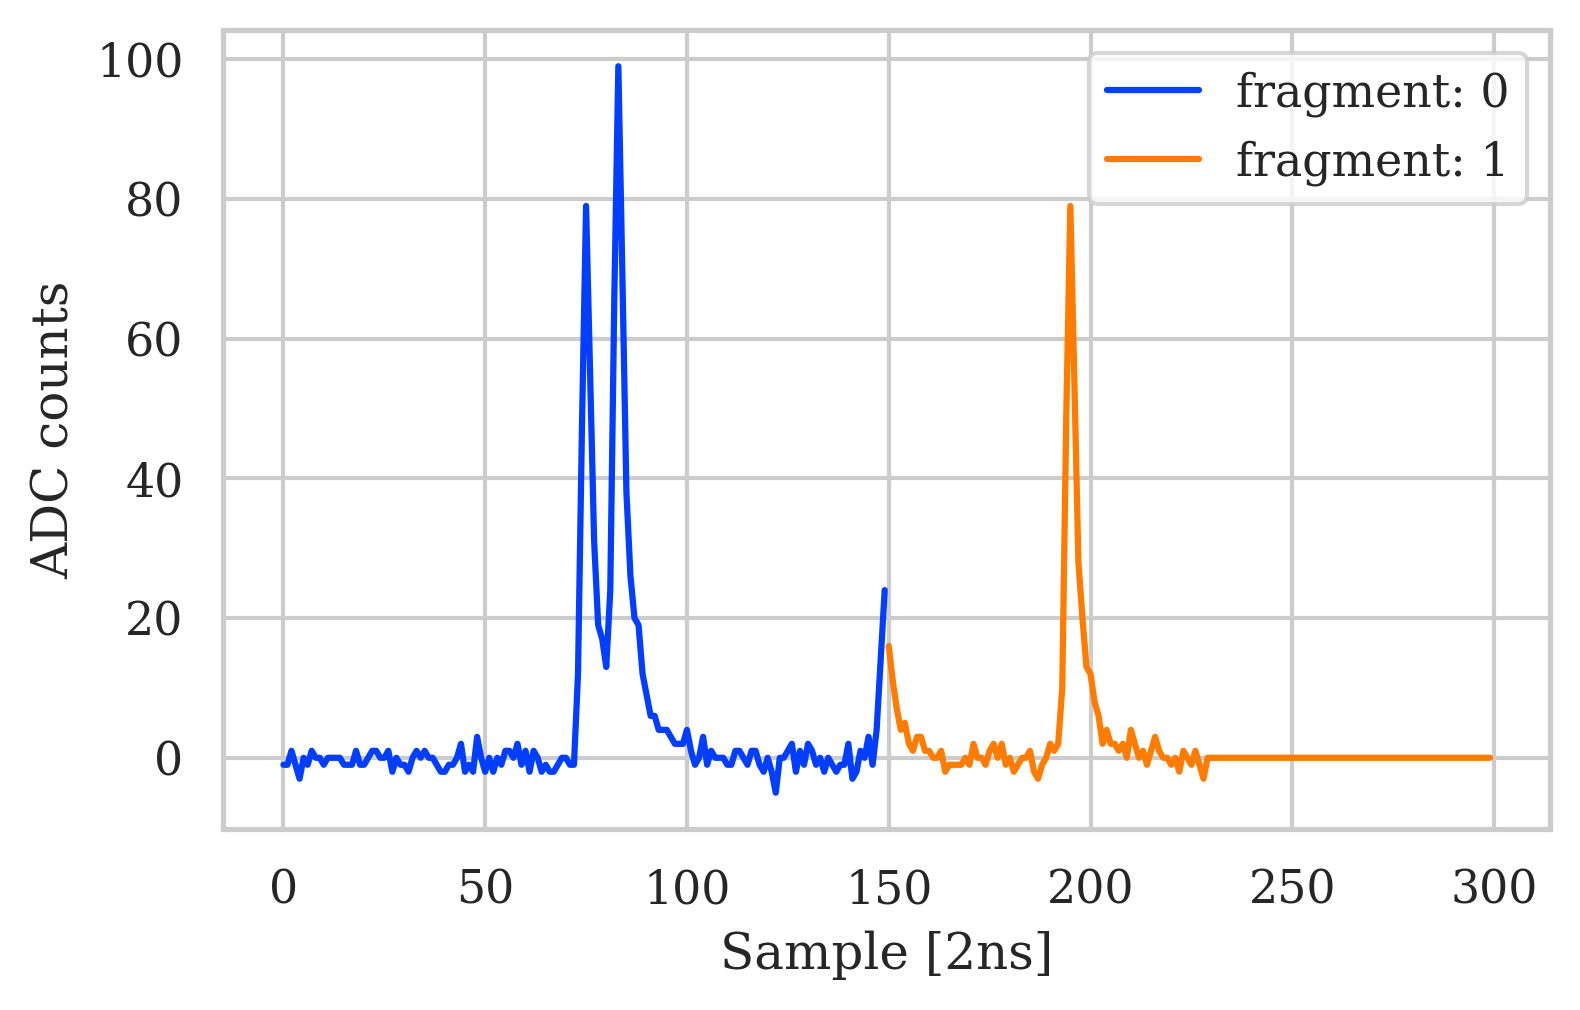

In [130]:
for ind, i in enumerate(p):
    plt.plot(np.arange(0, len(i)) + ind*len(i) , i, label=f'fragment: {ind}')
plt.xlabel('Sample [2ns]')
plt.ylabel('ADC counts')
plt.legend()

In [131]:
res

array([(230, 2, 2078, 146, 1390, -1916276450, 0, -0.30769232, 0, [-1, -1,  1, -1, -3,  0, -1,  1,  0,  0, -1,  0,  0,  0,  0, -1, -1, -1,  1, -1, -1,  0,  1,  1,  0,  0,  1, -2,  0, -1, -1, -2,  0,  1,  0,  1,  0,  0, -1, -2, -2, -1, -1,  0,  2, -2, -1, -2,  3,  0, -2,  0, -2,  0, -1,  1,  1,  0,  2, -1,  1, -2,  1,  0, -2, -1, -2, -2, -1,  0,  0, -1, -1, 12, 48, 79, 55, 31, 19, 17, 13, 24, 66, 99, 69, 38, 26, 20, 19, 12,  9,  6,  6,  4,  4,  4,  3,  2,  2,  2,  4,  1, -1,  0,  3, -1,  1,  0,  0,  0, -1, -1,  1,  1,  0, -1,  1,  1, -1, -2,  0, -2, -5,  0,  0,  1,  2, -2,  1, -1,  2,  1, -1,  0, -2,  0, -1, -2, -1, -1,  2, -3, -2,  1,  0,  3, -1,  4, 14, 24]),
       (230, 2, 2228, 146,  694, -1916276450, 1, -0.30769232, 0, [16, 11,  7,  4,  5,  2,  1,  3,  3,  1,  1,  0,  0,  1, -2, -1, -1, -1, -1,  0, -1,  2,  0,  0, -1,  1,  2,  0,  2, -1,  0, -2, -1,  0,  0,  1, -2, -3, -1,  0,  2,  1,  2, 10, 49, 79, 54, 28, 20, 13, 12,  8,  6,  2,  4,  2,  2,  1,  2,  0,  4,  2,  0,  1, -1,  1,  3